## ASHRAE - Great Energy Predictor III
## (얼마나 한 빌딩이 사용할까? 에너지 예측 대회)

매해 열리는 에너지 예측 대회입니다. 벌써 이번이 3번째 대회였습니다! Tabular Data를 사용하는 대회에 처음 하는 만큼 재밌었던 대회였습니다! 데이터는 대략 1000개 빌딩의 냉수 사용, 전기 사용, 온수 사용과 같은 변수들로 구성된형태로 제공되었습니다.

### 진행하면서 겪은 문제점

- 가장 어려웠던 점은 컴퓨터 성능이 따라갈수가 없었습니다. 그래서 모든 실험은 Kaggle Kernel에서 진행되었고 Kaggle의 kernel의 실행 제간 시간을 계속 확인하면서 진행하게 되었습니다.

# EDA

- 대회 초기부터 데이터의 결측값과 이상값이 많다는 이야기가 돌고 있었습니다. 특정 건물의 값이 전체 데이터에 영향을 주기도 하고, API_ERROR로 인해 결측값이 있다는것도 확인하게 되었습니다.
- 그래서 이런 결측값과 이상값을 탐지하는데 가장 많은 시간을 사용했습니다. 

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import random
import datetime

from tqdm import tqdm_notebook as tqdm

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing

import lightgbm as lgb

In [9]:
#데이터 가져오기 / 조인
building = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv')
train = pd.read_csv('../input/ashrae-energy-prediction/train.csv')
test = pd.read_csv('../input/ashrae-energy-prediction/test.csv')
train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')

train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
del weather_train, weather_test,building
gc.collect();

In [10]:
# 메모리 절약을 위한 데이터 타입 변환!
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}

for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    test[feature] = test[feature].astype(d_types[feature])
    
train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])
gc.collect();

### 결측값 나타내기

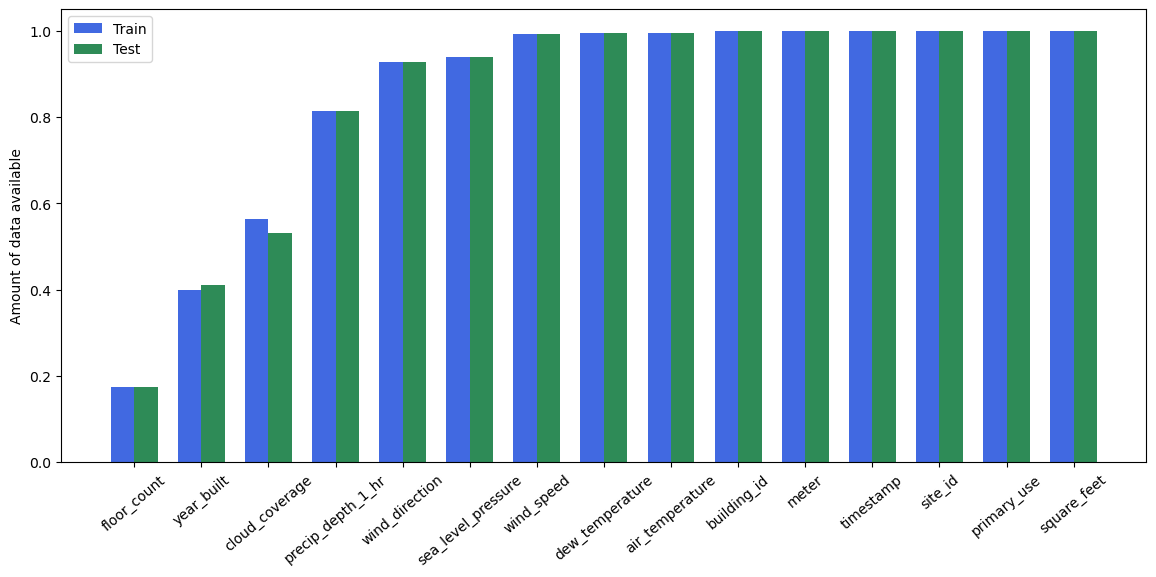

In [11]:
train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = (test.count() / len(test)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);

## 일간 평균 에너지 소비량

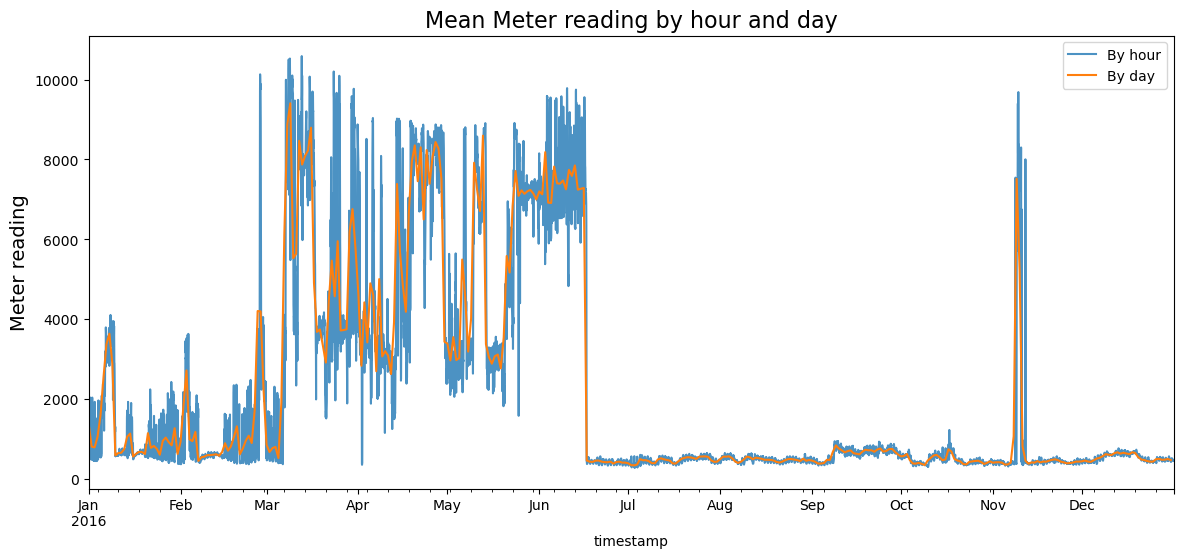

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day', fontsize=16);
axes.legend();

- 이상한 점은 1월달부터 3월까지는 평균값을 웃돌지만 3월초가 지나면 에너지소비가 폭발적으로 증가합니다. 
- 그래서 건물마다 소비량을 살펴봤습니다

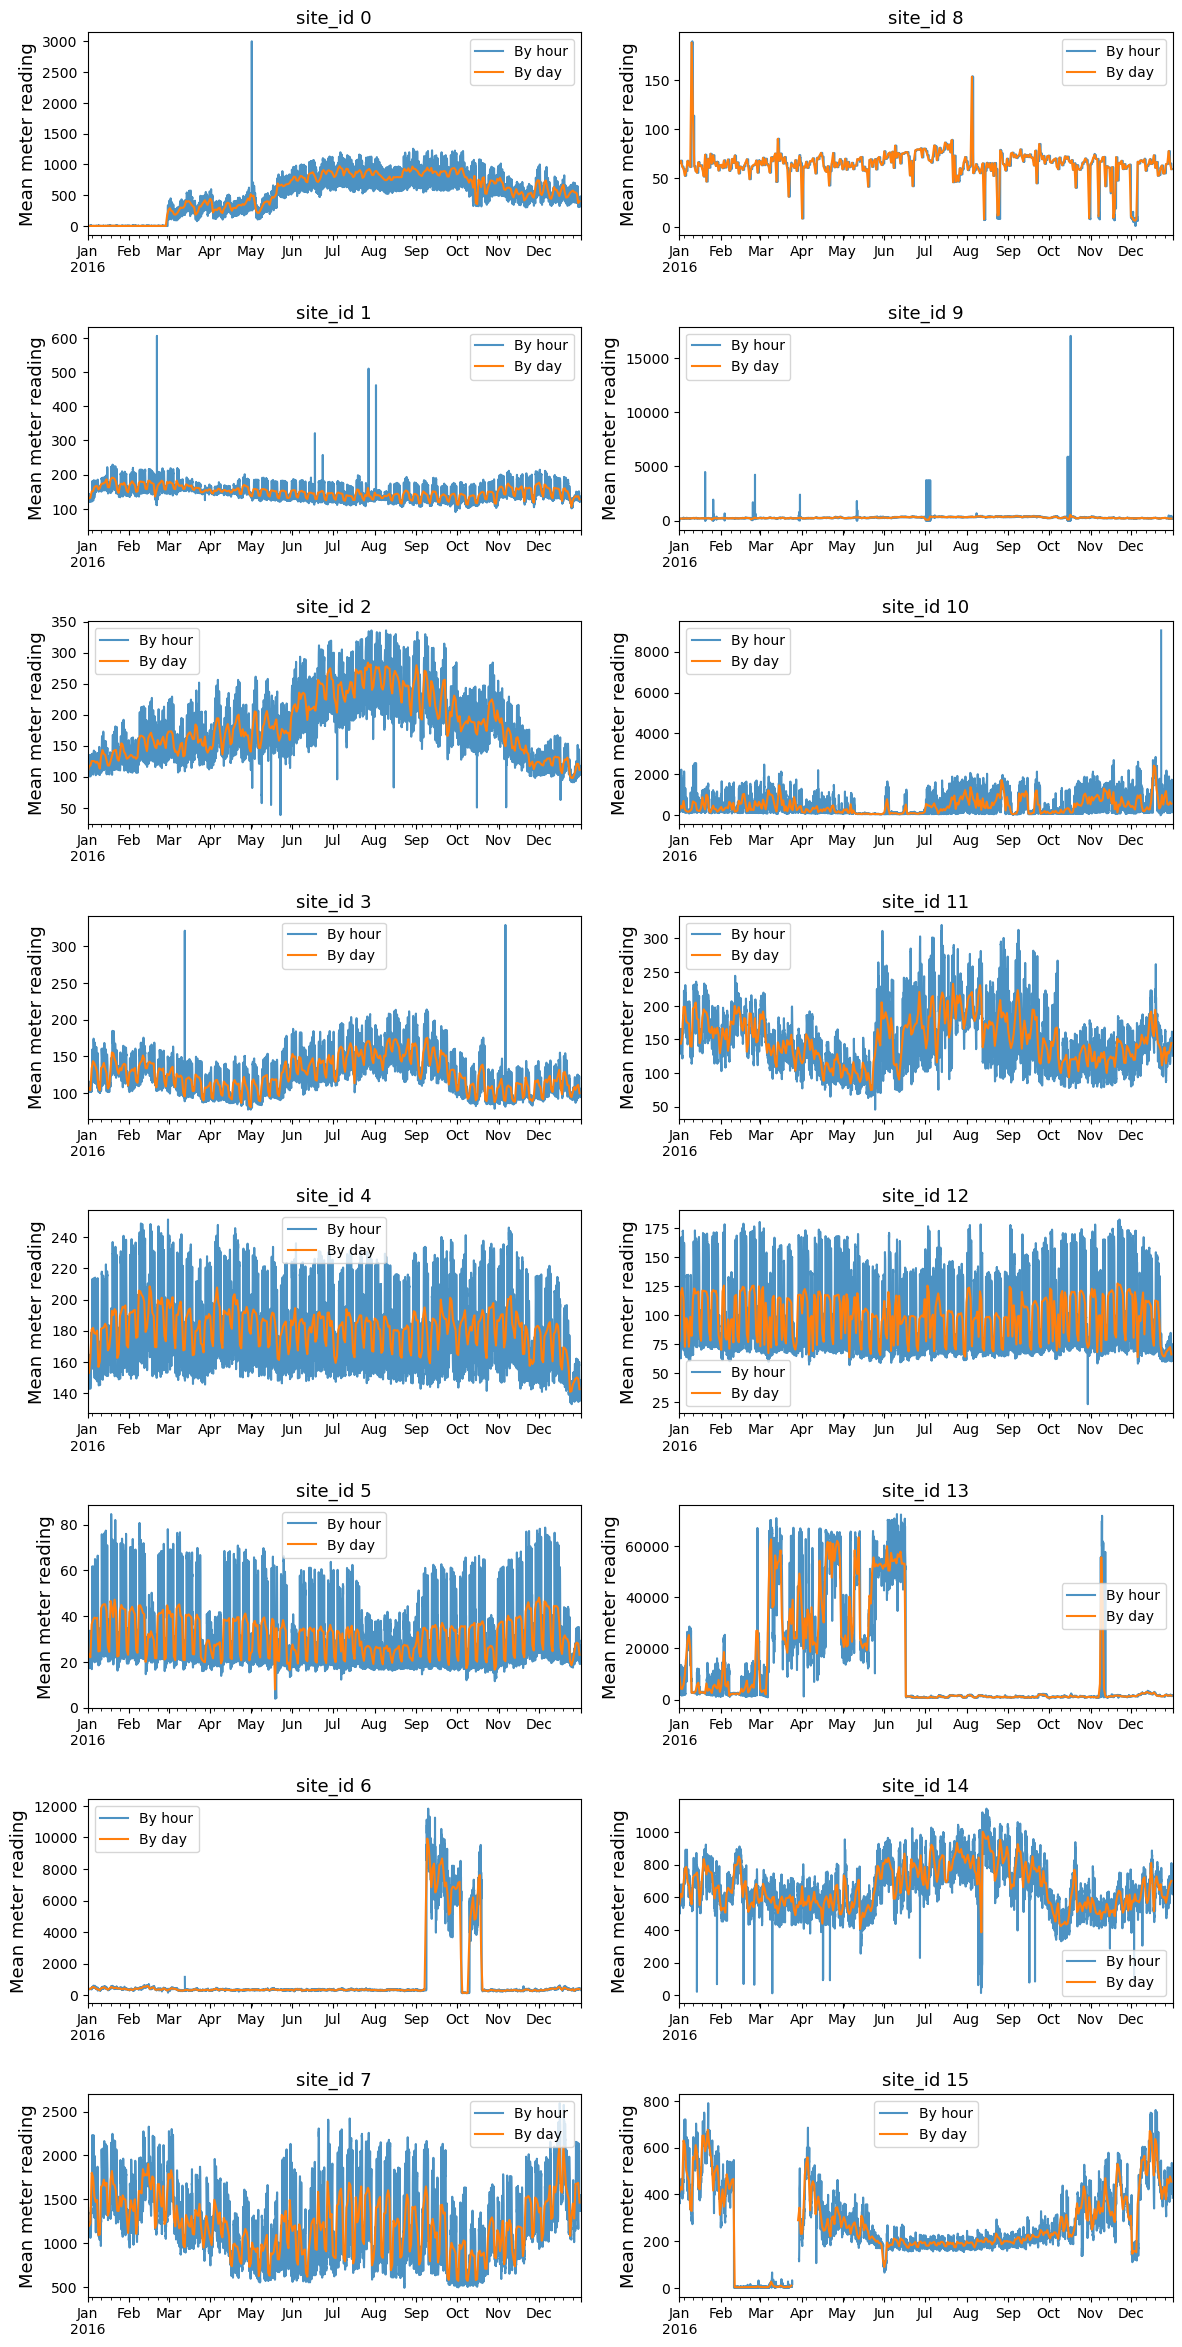

In [13]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

> ### 특정 건물의 시각화를 통해 알아낸점
- 건물 0번은 어느기간이 지나면 소비량이 0이 되어 버립니다. 건물이 공실이 되었거나, 공사를 했을까요? 모든 건물을 데이터에 넣을 필요는 없다는 것을 확인하였습니다.
- 건물 13번이 전체 평균 에너지 소비와 비슷하게 생긴걸 확인하게 되었습니다. 
- 그래서 건물 13번의 주요 사용원을 알아보게 되었습니다.

### 건물 13번의 주요 사용처

IndexError: index 0 is out of bounds for axis 0 with size 0

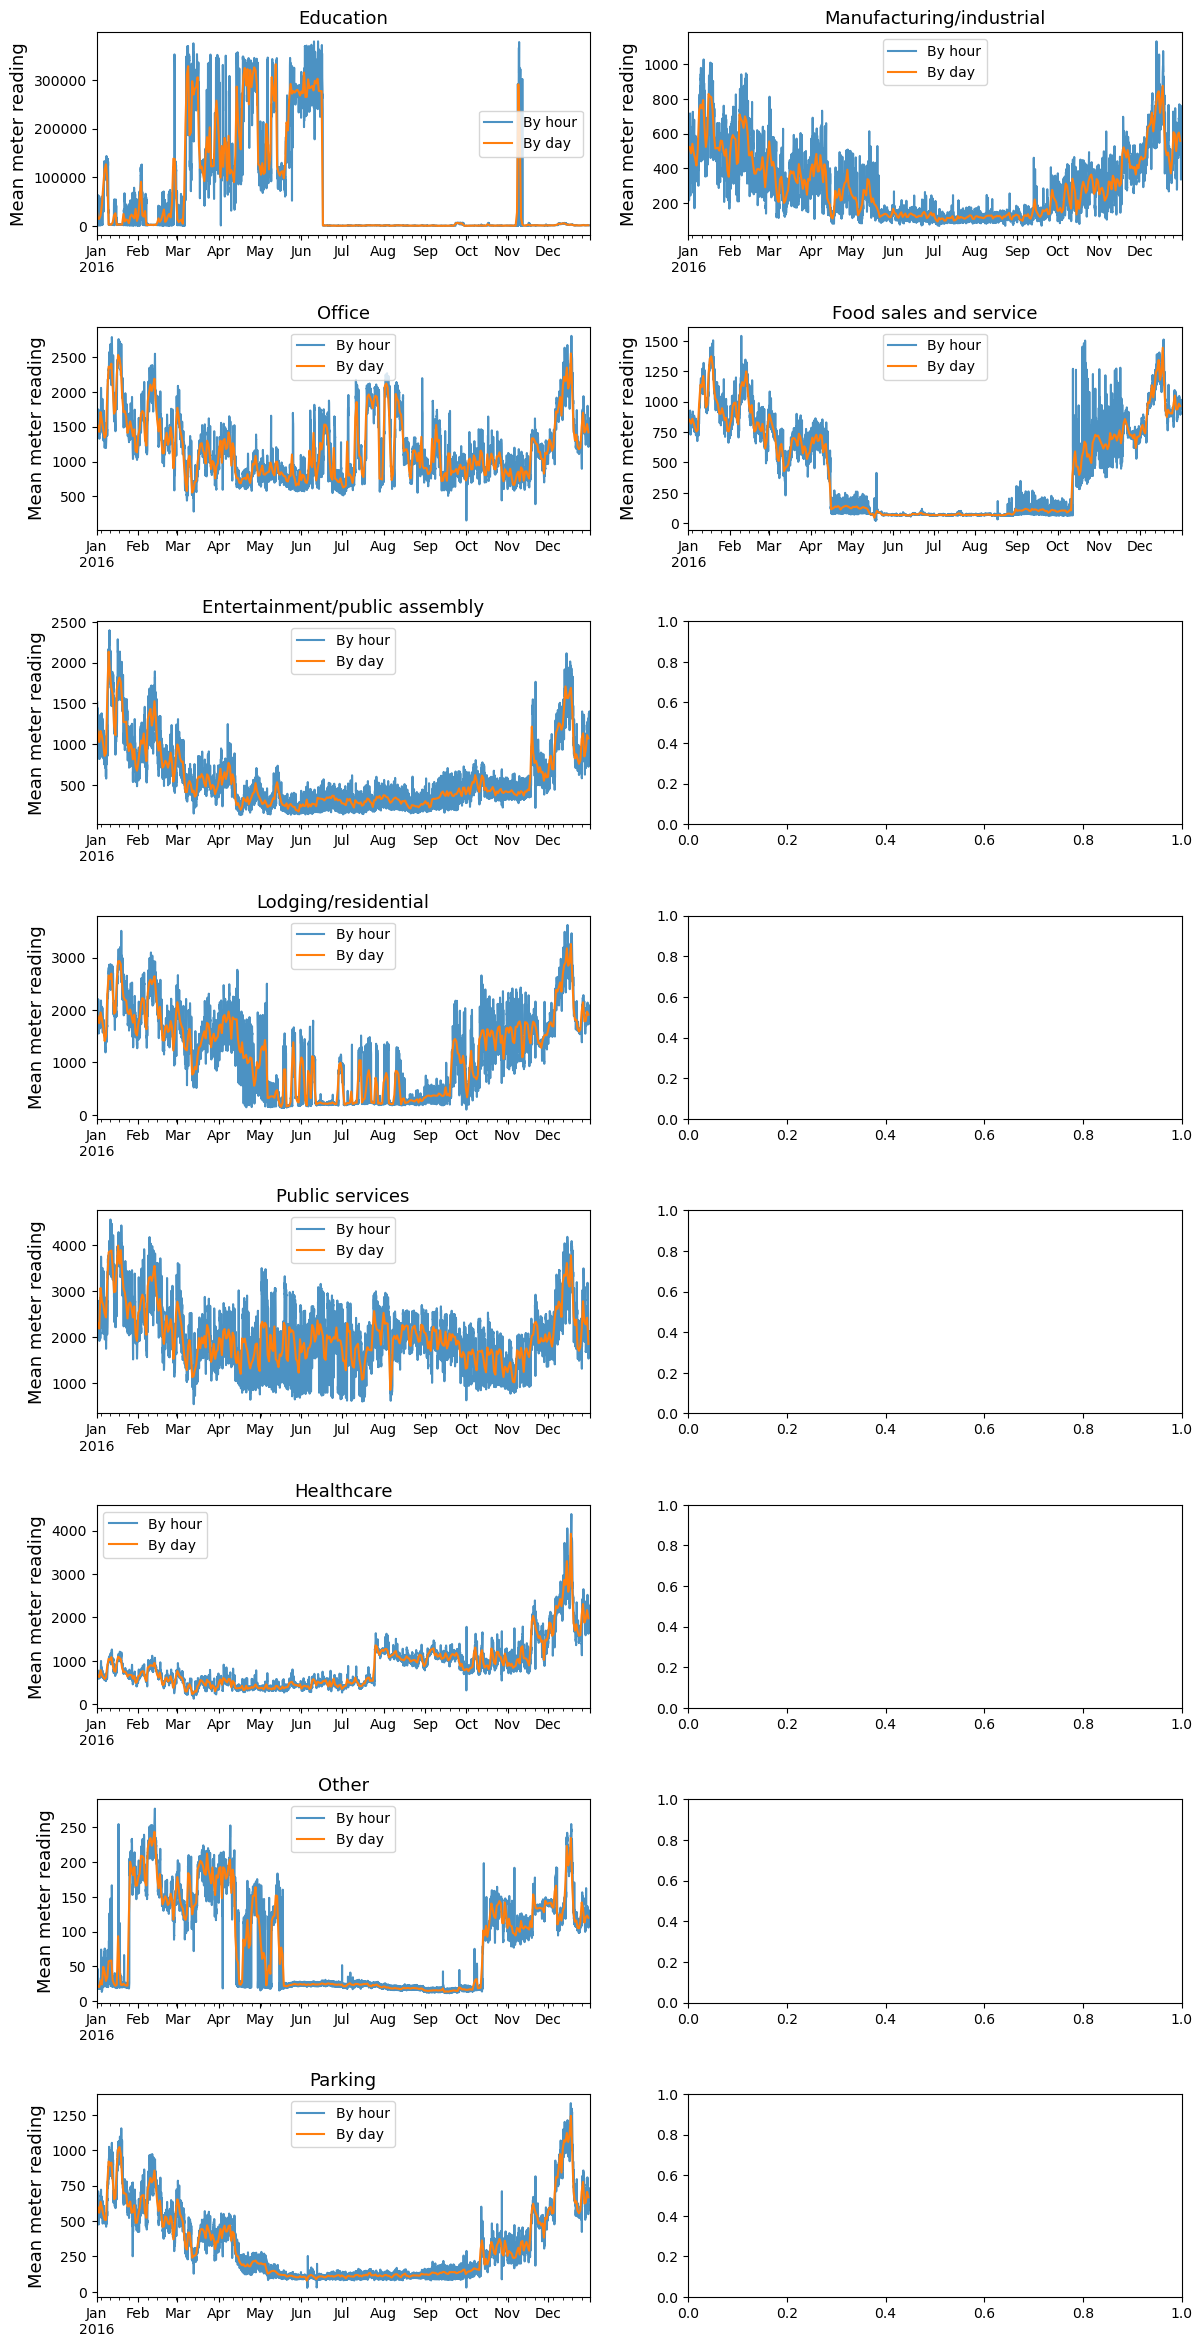

In [14]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i, use in enumerate(train['primary_use'].value_counts().index.to_list()):
    try:
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
        axes[i%8][i//8].legend();
    except TypeError:
        pass
    axes[i%8][i//8].set_title(use, fontsize=13);
    plt.subplots_adjust(hspace=0.45)

### 13번 건물의 시각화를 통해 확인한 점
- 13번 건물, 주 용도 교육, 전체 평균 에너지 소비 이 3개의 그래프가 거의 동일하다는 것을 알 수 있었습니다.
- 그래서 13번 건물의 주요 에너지 소비 자원들을 확인해봤습니다

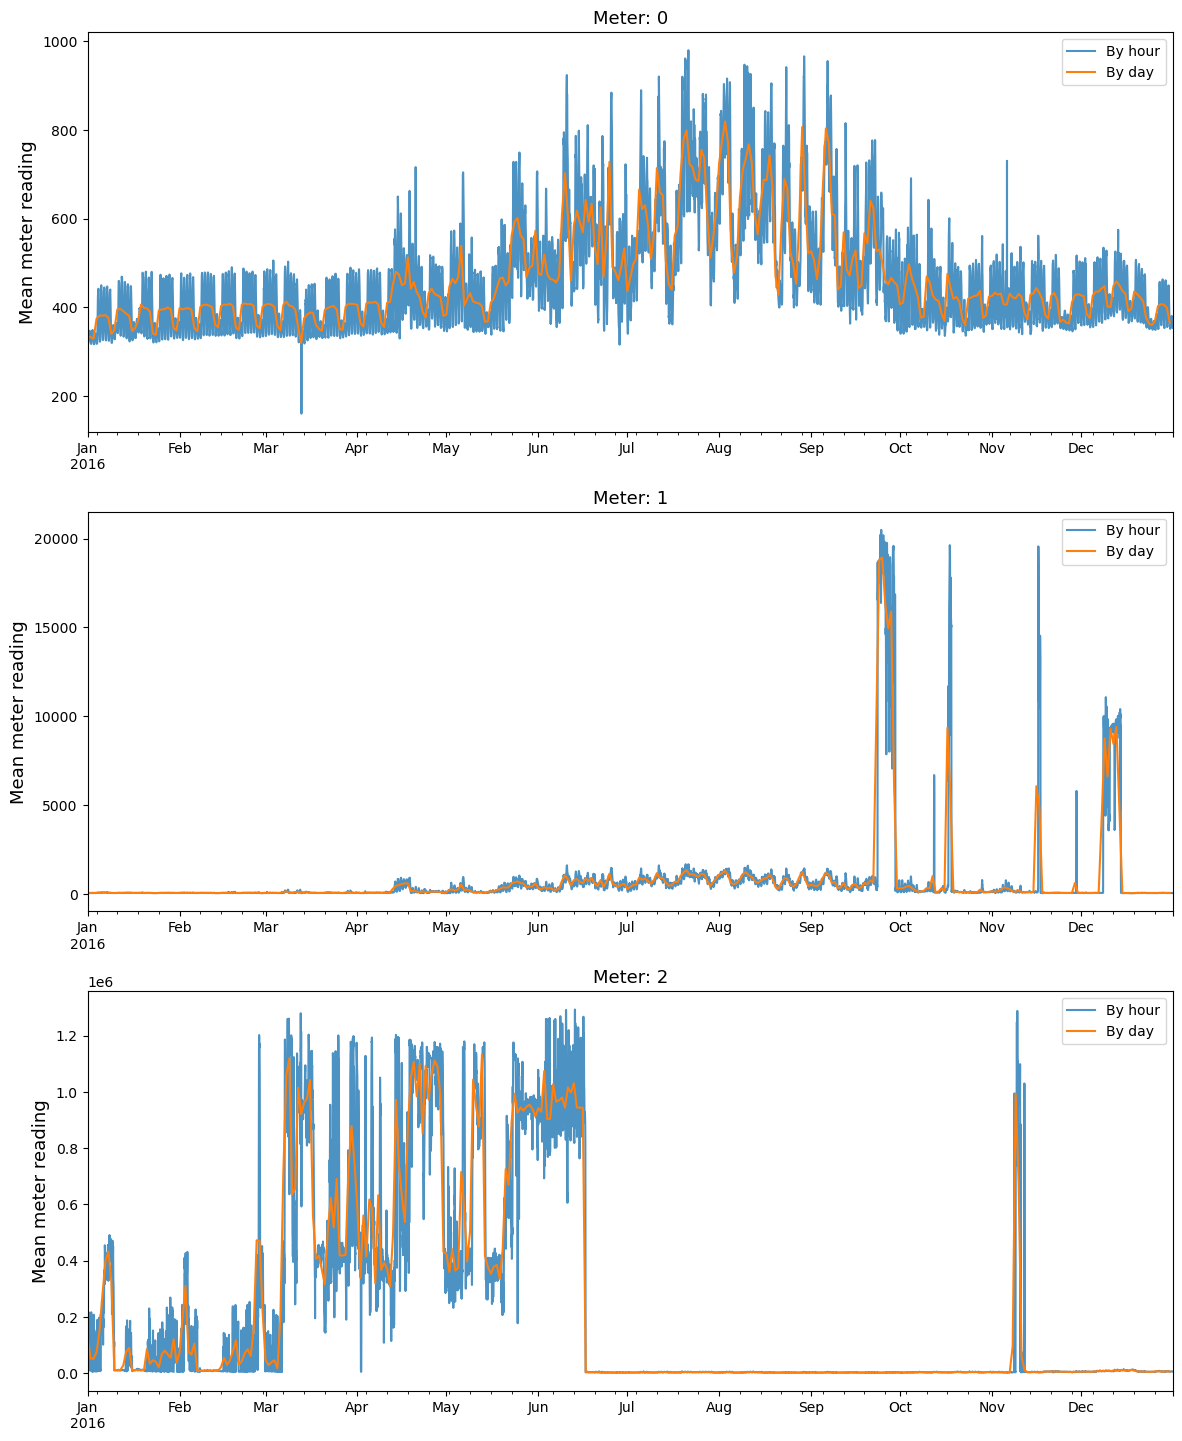

In [16]:
fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
for i in train[(train['site_id'] == 13) & (train['primary_use'] == 'Education')]['meter'].value_counts(dropna=False).index.to_list():
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i].legend();
    axes[i].set_title('Meter: ' + str(i), fontsize=13);

* 위의 그래프를 통해서, **13번 건물**의 **교육 용도**의 **2번 에너지 타입**이 전체적인 데이터에 큰 영향을 미치고 있다는 것을 알수있습니다.
* 저는 이런 형태의 그래프가 또 있을것 같다는 생각이 들어서 다른 건물들도 살펴보았습니다.

fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
for i in train[(train['site_id'] == 13) & (train['primary_use'] == 'Education')]['meter'].value_counts(dropna=False).index.to_list():
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i].legend();
    axes[i].set_title('Meter: ' + str(i), fontsize=13);

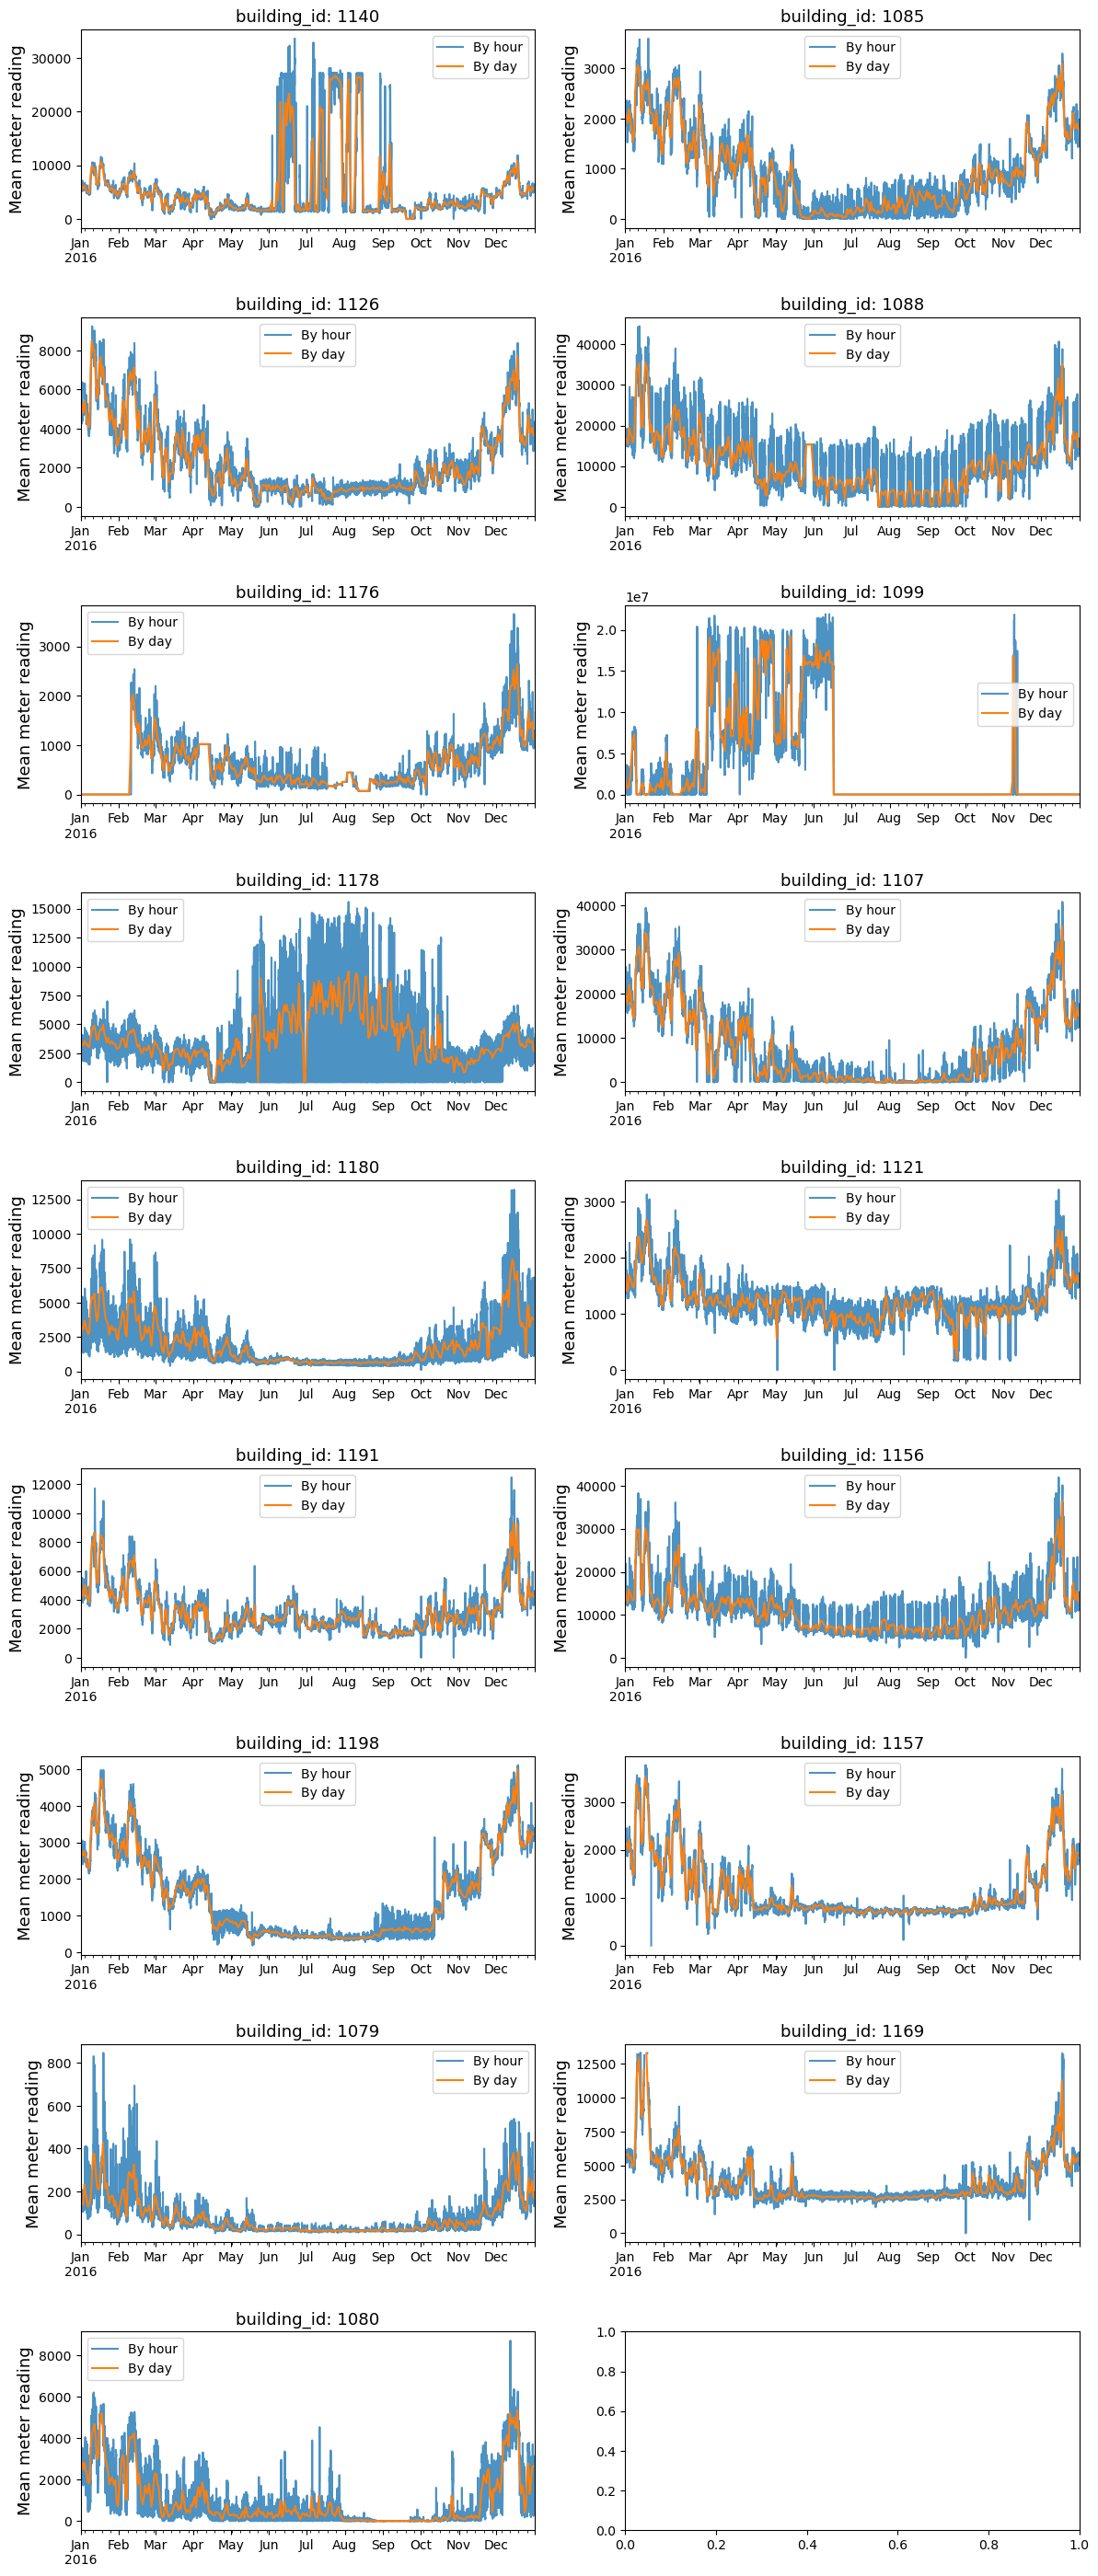

In [18]:
fig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
for i, building in enumerate(train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2)]['building_id'].value_counts(dropna=False).index.to_list()):
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2) & (train['building_id'] == building)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%9][i//9], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2) & (train['building_id'] == building)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%9][i//9], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%9][i//9].legend();
    axes[i%9][i//9].set_title('building_id: ' + str(building), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

* 1099번을 역시 전체 평균데이터와 동일한 모습을 가지고 있습니다. 그래서 1099번을 제외하기 전, 제외하고 난 후의 플롯을 그려봤습니다. 

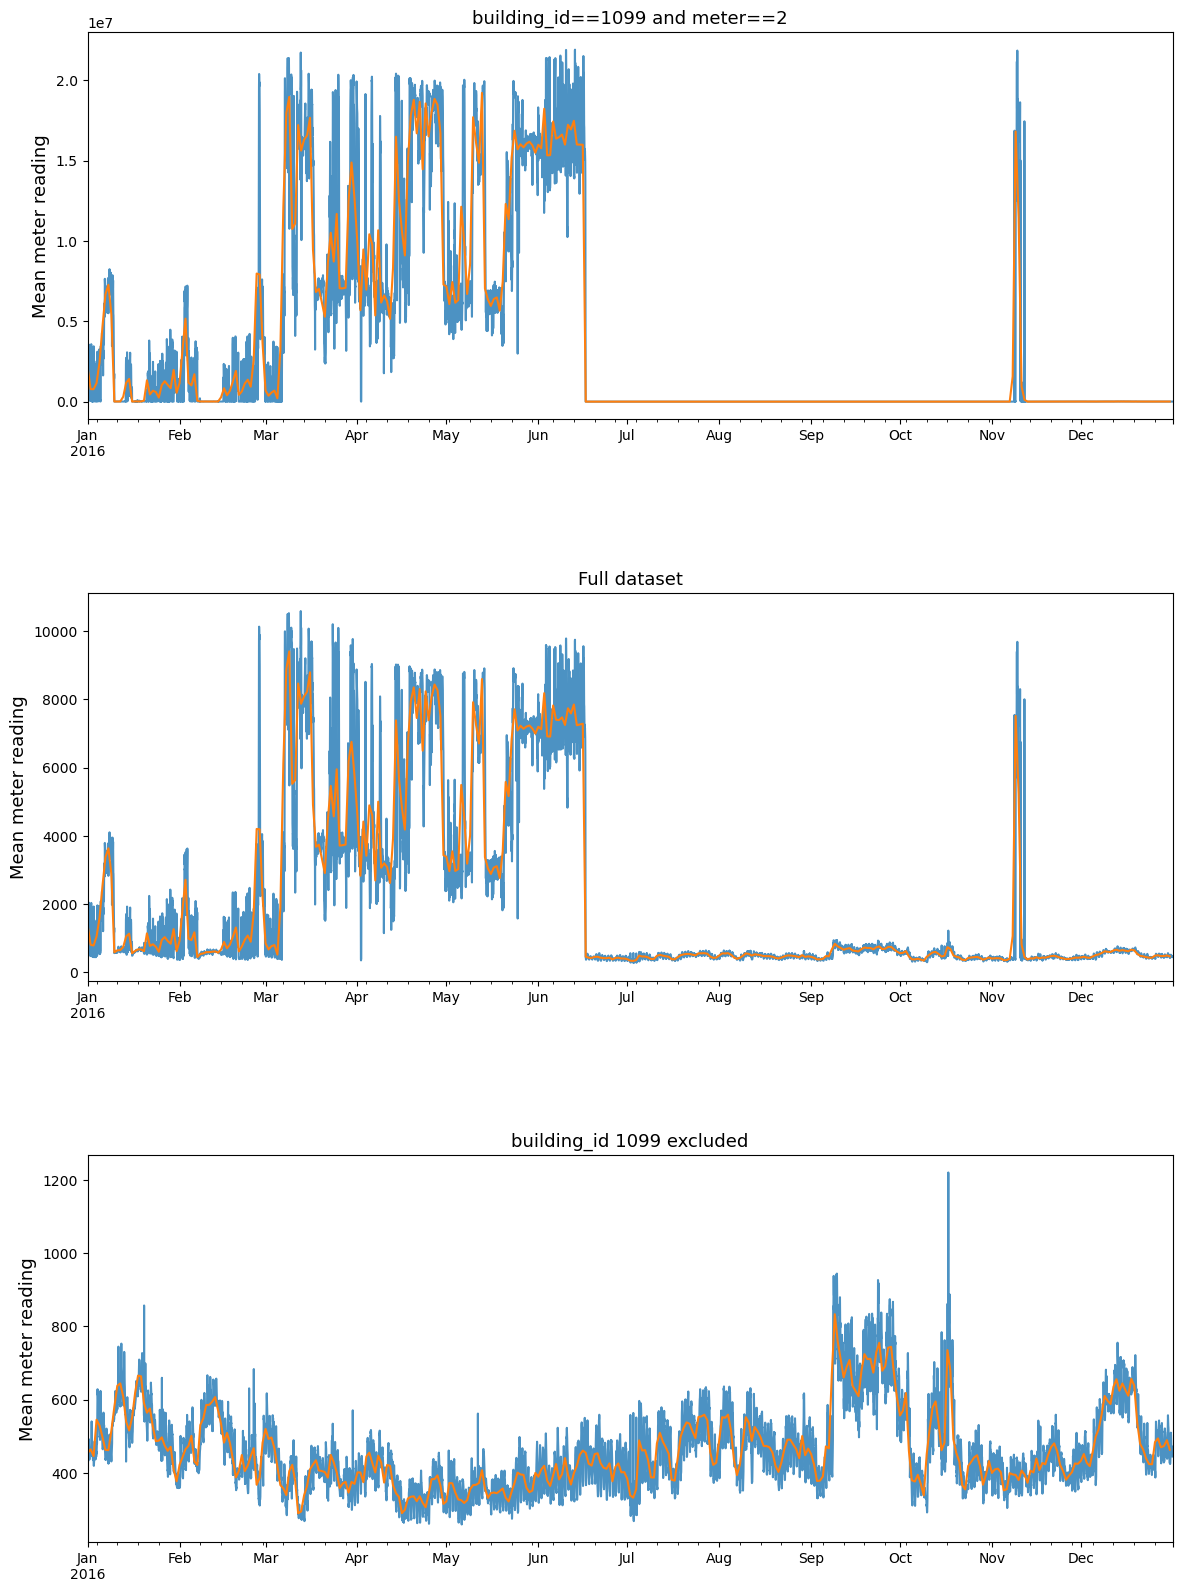

In [19]:
fig, axes = plt.subplots(3,1,figsize=(14, 20), dpi=100)

train[(train['meter'] == 2) & (train['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[0], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[(train['meter'] == 2) & (train['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[0], alpha=1, label='By day', color='tab:orange').set_xlabel('');

train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[1], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[1], alpha=1, label='By day', color='tab:orange').set_xlabel('');

train[~((train['meter'] == 2) & (train['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[2], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[~((train['meter'] == 2) & (train['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[2], alpha=1, label='By day', color='tab:orange').set_xlabel('');

axes[0].set_title('building_id==1099 and meter==2', fontsize=13);
axes[1].set_title('Full dataset', fontsize=13);
axes[2].set_title('building_id 1099 excluded', fontsize=13);
plt.subplots_adjust(hspace=0.45)

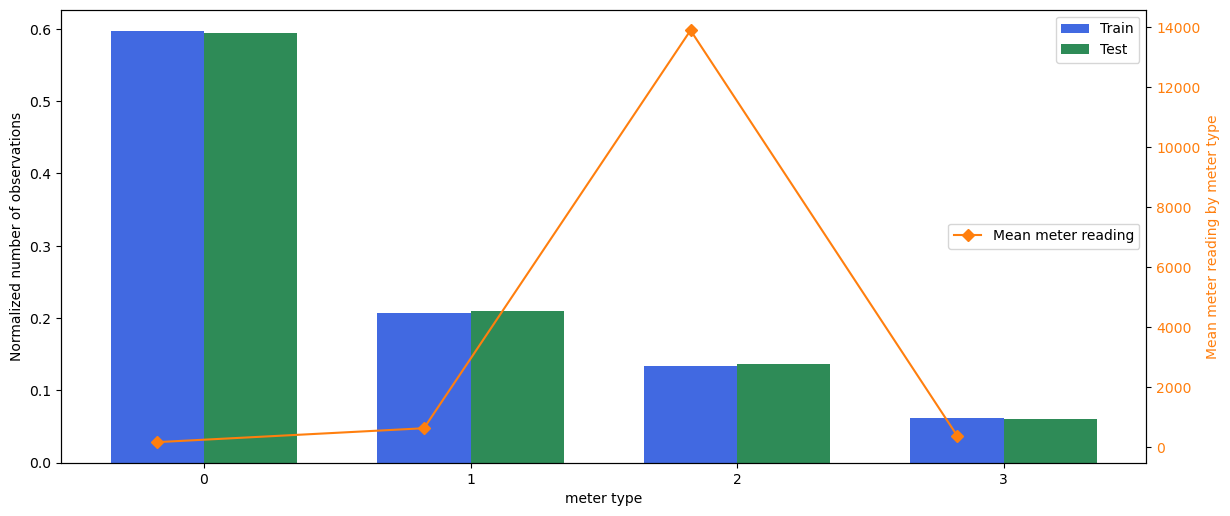

In [20]:
train_data = train['meter'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['meter'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('meter type');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['meter'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['meter', 'meter_reading']].groupby('meter')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by meter type', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

### Meter(에너지소비)
- 가장 중요한 변수중 하나인 에너지 소비에 대해 시각화를 해보았습니다. 에너지는 {0:전기, 1:냉수, 2:온수, 3:뜨거운 물} cf. 모든 건물이 4개의 에너지에 대한 데이터를 가지고 있지는 않습니다.

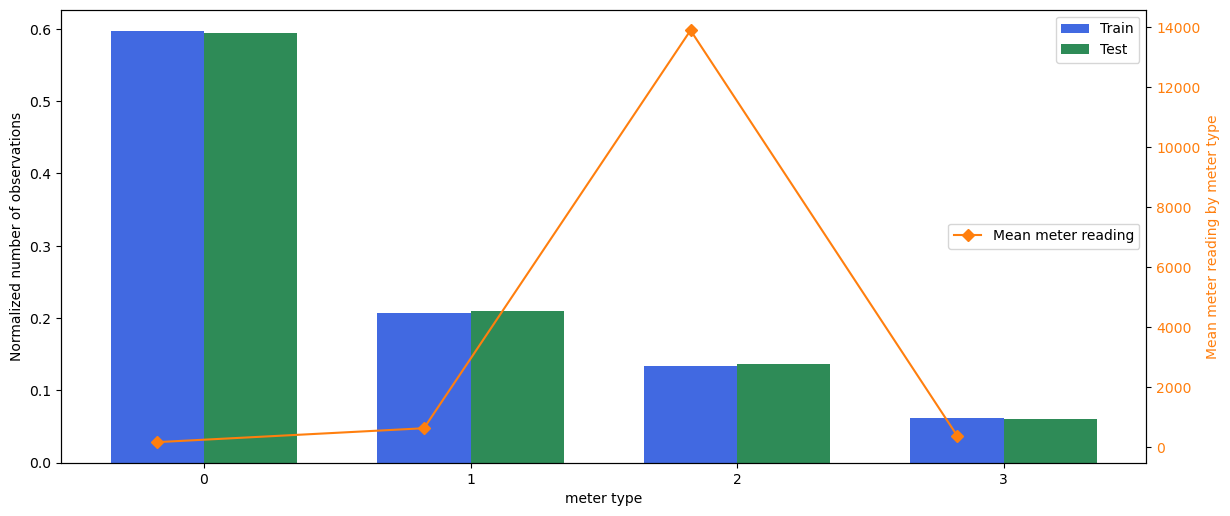

In [21]:
train_data = train['meter'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['meter'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('meter type');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['meter'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['meter', 'meter_reading']].groupby('meter')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by meter type', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

### 각 에너지간의 Box plot

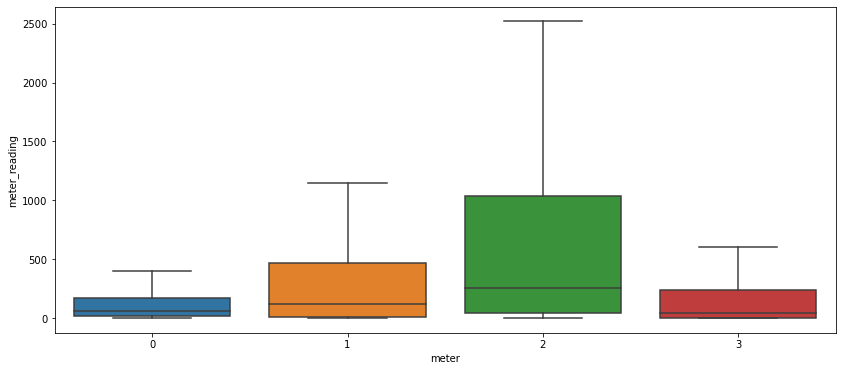

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=False);

### 건물간의 데이터 수

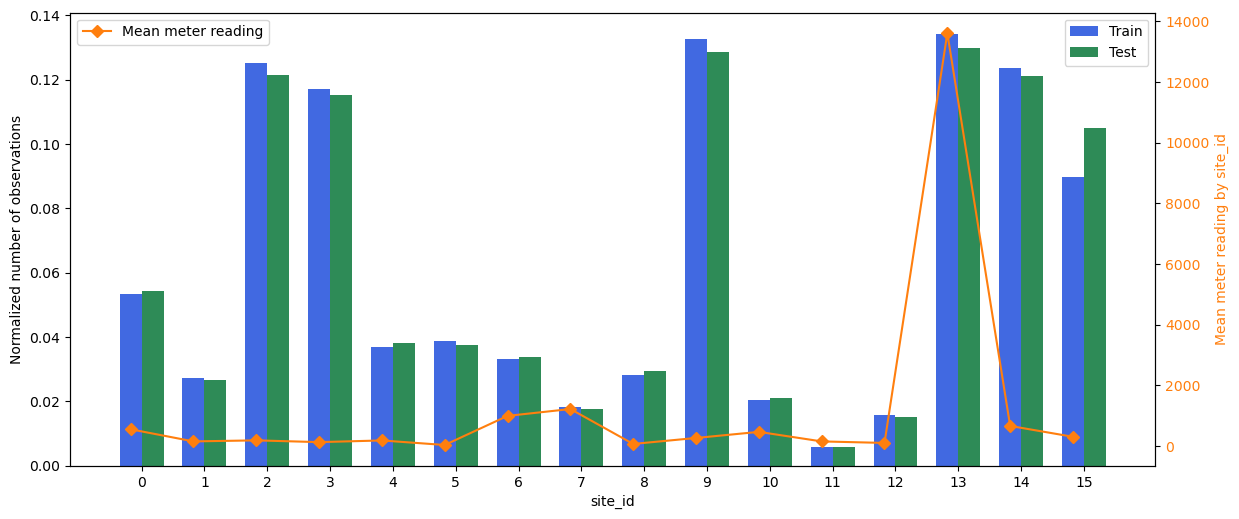

In [23]:
train_data = train['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('site_id');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['site_id'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['site_id', 'meter_reading']].groupby('site_id')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by site_id', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

### 주요 에너지 소비원

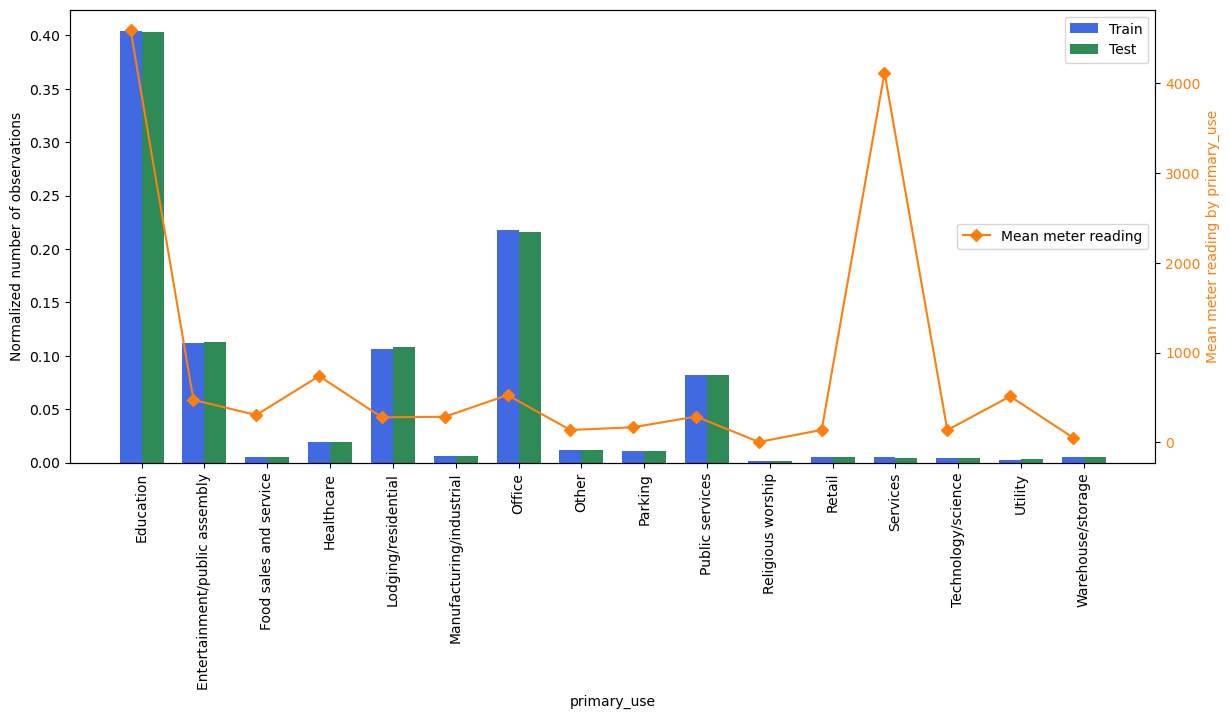

In [24]:
train_data = train['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('primary_use');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['primary_use'].value_counts().sort_index().index, rotation=90)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['primary_use', 'meter_reading']].groupby('primary_use')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by primary_use', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

# Modeling

### Baseline Model들부터 사용하면서 데이터에 대해 감을 익혔습니다

1. 대회 시작은 각 변수마다 Mean과 Median을 살펴보면서 [Naive Mean Model](https://www.kaggle.com/vladimirsydor/naivemeanpredictor)이라는 모델을 사용했습니다. Performance는 1.39~1.4(public LB)였지만, 좀 더 정교한 모델을 사용할 수 있는 기반이 되었습니다
2. 그다음에 [RandomForestRegressor](https://www.kaggle.com/vladimirsydor/randomforestbaseline)를 사용했습니다. 엄청 느리고 좋은 점수를 받지는 못했습니다.
3. 여러 곳에서 LightGBM모델로 좋은 결과를 얻었다는 처음으로 소식을 듣고 LightGBM 모델을 사용해봤습니다.

In [25]:
class MyRegressor(object):
    def __init__(self, ml_params, categoricals, nmm_params=None, cols_to_drop=[], tgt_variable='meter_reading', correct_site_0=False):
        self.ml = None
        self.ml_params = ml_params
        
        if nmm_params is not None:
            self.naive_mean_model = NaiveMeanModel(**nmm_params)
        else: 
            self.naive_mean_model = None
        
        self.tgt_variable = tgt_variable
        self.categoricals = categoricals
        self.cols_to_drop = cols_to_drop
        self.correct_site_0 = correct_site_0
        
        self.predictors = None
        
    def fit(self, X, X_val=None, plot_feature_imp=True):
        if self.correct_site_0:
            X.loc[X['site_id']==0, self.tgt_variable] = X.loc[X['site_id']==0, self.tgt_variable] * 0.2931
            
        if self.naive_mean_model is not None:
            X['stat'] = self.naive_mean_model.out_of_fold_predict(X)
            self.naive_mean_model.fit(X)
        
        y = X[self.tgt_variable]
        X = X.drop(columns=[self.tgt_variable] + self.cols_to_drop)
        
        col_names = X.columns
        self.predictors = list(col_names)
        
        X = X[self.predictors].values.astype(np.float32)
        X = lgb.Dataset(X, label=y,feature_name=self.predictors, categorical_feature=self.categoricals)    
        
        if X_val is not None:
            if self.correct_site_0:
                X_val.loc[X_val['site_id']==0, self.tgt_variable] = X_val.loc[X_val['site_id']==0, self.tgt_variable] * 0.2931
                
            if self.naive_mean_model is not None:    
                X_val['stat'] = self.naive_mean_model.predict(X_val)
            
            y_val = X_val[self.tgt_variable]
            X_val = X_val.drop(columns=[self.tgt_variable] + self.cols_to_drop)
            
            X_val = X_val[self.predictors].values.astype(np.float32)
            X_val = lgb.Dataset(X_val, label=y_val, 
                                feature_name = self.predictors, categorical_feature=self.categoricals)
            
            self.ml = lgb.train(self.ml_params,
                                X,
                                num_boost_round=MAX_BOOST_ROUNDS,
                                valid_sets=(X, X_val),
                                early_stopping_rounds=EARLY_STOPPING,
                                verbose_eval = 50)
        else:
            self.ml = lgb.train(self.ml_params,
                                X,
                                valid_sets=(X),
                                num_boost_round=MAX_BOOST_ROUNDS,
                                verbose_eval = 50)
        if plot_feature_imp:
            plotImp(self.ml, col_names)
            
        return self
    
    def predict(self, X):
        if self.correct_site_0:
            site_0_mask = np.array(X['site_id']==0)   
            
        if self.naive_mean_model is not None:
            X['stat'] = self.naive_mean_model.predict(X)
        
        cols_to_drop = list(set(['row_id', self.tgt_variable] + self.cols_to_drop) & set(X.columns))
        
        batches = int(np.ceil(X.shape[0]/BATCH_SIZE))
        
        res=[]
        for i in tqdm(range(batches)):
            res.append(self.ml.predict( X.iloc[i*BATCH_SIZE:(i+1)*BATCH_SIZE].drop(columns=cols_to_drop)[self.predictors].values.astype(np.float32) ))
            
        res = np.concatenate(res)
        
        if self.correct_site_0:
            res[site_0_mask] = res[site_0_mask] * 3.4118
            
        return res

In [ ]:


def one_fold_predict(data, model, metric=LRMSE, target_var_name='meter_reading', test_to_predict=None):    
    print('Starting Validation')
    print('Fold {}'.format(FOLD_NUMBER))
    
    model.fit(data[data['k_folds'] != FOLD_NUMBER].reset_index(drop=True), data[data['k_folds'] == FOLD_NUMBER].reset_index(drop=True))
    pred = model.predict(data[data['k_folds'] == FOLD_NUMBER].reset_index(drop=True))
        
    if test_to_predict is not None:
        test_prediction = model.predict(test_to_predict)
            
    itter_metric = metric(data.loc[data['k_folds'] == FOLD_NUMBER, target_var_name], pred)
    print('Fold metric: '+str(itter_metric))
    
    gc.collect()
     
    if test_to_predict is not None:
        return itter_metric, test_prediction
    else:
        return itter_metric


    

boost_model = MyRegressor(ml_params={
            "objective": "regression",
            "boosting": "gbdt",
            "num_leaves": 145,
            "learning_rate": 0.05,
            "feature_fraction": 0.85,
            "reg_lambda": 1,
            "metric": "rmse",
            'seed':42,
    
            'bagging_seed': 42,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'max_depth': 13,
            'subsample_freq': 5,
            'subsample': 0.8
            }, categoricals=cat_columns, cols_to_drop=['k_folds','index'])



rf_res, X_test['meter_reading'] = one_fold_predict(X_train, boost_model, test_to_predict=X_test)




* 처음 쓰는 모델이였기 때문에 Hyperparameter설정에 시간을 많이사용하였습니다. 처음 training시에는 너무나 시간이 오래걸렸습니다. 
* 많은 시행착오를 겪은 결과 'leaf'의 수를 늘리면 model의 성과향상에 많은 도움이 된다는 것을 알게 되었습니다.(82, 145를 시도해봤습니다)